# Training data

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab

    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/pypd.git
    print("Package installed successfully")
    import pypd

    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
except ImportError:
    IN_COLAB = False
    import pypd

    print("Not running in Colab")

Not running in Colab


In [2]:
if IN_COLAB:
    try:
        gpu_info = !nvidia-smi
        gpu_info = "\n".join(gpu_info)
        print("GPU Information:")
        print(gpu_info)
    except:
        print("GPU information not available")

    try:
        import multiprocessing

        cpu_info = f"Number of CPU cores: {multiprocessing.cpu_count()}"
        print("\nCPU Information:")
        print(cpu_info)
    except:
        print("CPU information not available")
else:
    print("Not running in Colab.")

Not running in Colab.


### Functions required to build the input file

In [3]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    """
    Build particle coordinates

    Parameters
    ----------

    Returns
    -------

    Notes
    -----

    """
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):  # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

In [4]:
def build_boundary_conditions(particles, dx):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)

    tol = 1e-6

    for i, particle in enumerate(particles):
        if particle[0] < (0.02 + tol):
            bc_flag[i, 0] = 1
            bc_unit_vector[i, 0] = -1
        if particle[0] > (0.48 - dx - tol):
            bc_flag[i, 0] = 1
            bc_unit_vector[i, 0] = 1

    return bc_flag, bc_unit_vector

In [5]:
def build_hole(particles, centre, radius):
    """
    Build hole in 2D plate

    Parameters
    ----------

    Returns
    -------

    Notes
    -----
    """

    counter = 0
    mask = []

    for particle in particles:
        distance = np.sqrt(
            (particle[0] - centre[0]) ** 2 + (particle[1] - centre[1]) ** 2
        )

        if distance < radius:
            mask.append(counter)

        counter += 1

    return np.delete(particles, mask, axis=0)

### Build the particles and boundary conditions

In [26]:
dx = 1.25e-3
n_div_x = np.rint(0.5 / dx).astype(int)
n_div_y = np.rint(0.25 / dx).astype(int)

hole_1_centre_x = np.random.uniform(0.05, 0.15)
hole_1_centre_y = np.random.uniform(0.05, 0.2)

hole_2_centre_x = np.random.uniform(0.2, 0.3)
hole_2_centre_y = np.random.uniform(0.05, 0.2)

hole_3_centre_x = np.random.uniform(0.35, 0.45)
hole_3_centre_y = np.random.uniform(0.05, 0.2)

x = build_particle_coordinates(dx, n_div_x, n_div_y)
x = build_hole(x, [hole_1_centre_x, hole_1_centre_y], np.random.uniform(0.02, 0.08))
x = build_hole(x, [hole_2_centre_x, hole_2_centre_y], np.random.uniform(0.02, 0.08))
x = build_hole(x, [hole_3_centre_x, hole_3_centre_y], np.random.uniform(0.02, 0.08))
flag, unit_vector = build_boundary_conditions(x, dx)

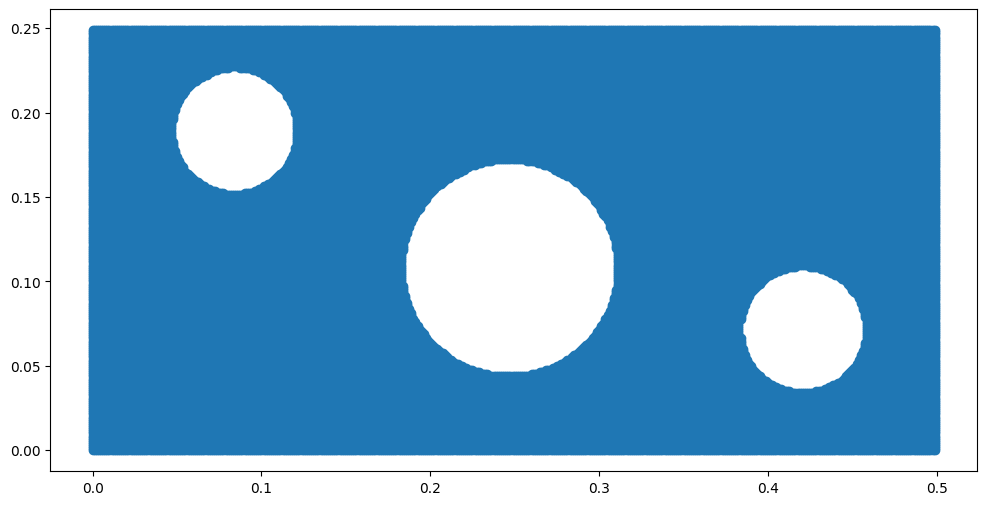

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x[:, 0], x[:, 1])
ax.set_aspect("equal")

### Build the model

If we are only interested in studying the deformed shape of the plate, we can switch off damage in the `ConstitutiveModel` class by setting `damage_on` to `False`.

In [28]:
material = pypd.Material(name="quasi-brittle", E=33e9, Gf=130, density=2400, ft=2.5)
integrator = pypd.EulerCromer()
bc = pypd.BoundaryConditions(flag, unit_vector, magnitude=1e-4)
particles = pypd.ParticleSet(x, dx, bc, material)
linear = pypd.Linear(material, particles, t=dx, damage_on=False)
bonds = pypd.BondSet(particles, linear)
simulation = pypd.Simulation(dt=None, n_time_steps=20000, damping=0)

model = pypd.Model(
    particles,
    bonds,
    simulation,
    integrator,
    linear,
)

In [29]:
model.run_simulation()

Simulation Progress: 100%|███████████████████████████████████████████████| 20000/20000 [02:49<00:00, 117.96steps/s]


### Visualise the deformation of the plate

In [30]:
dsf = 100  # displacement scale factor

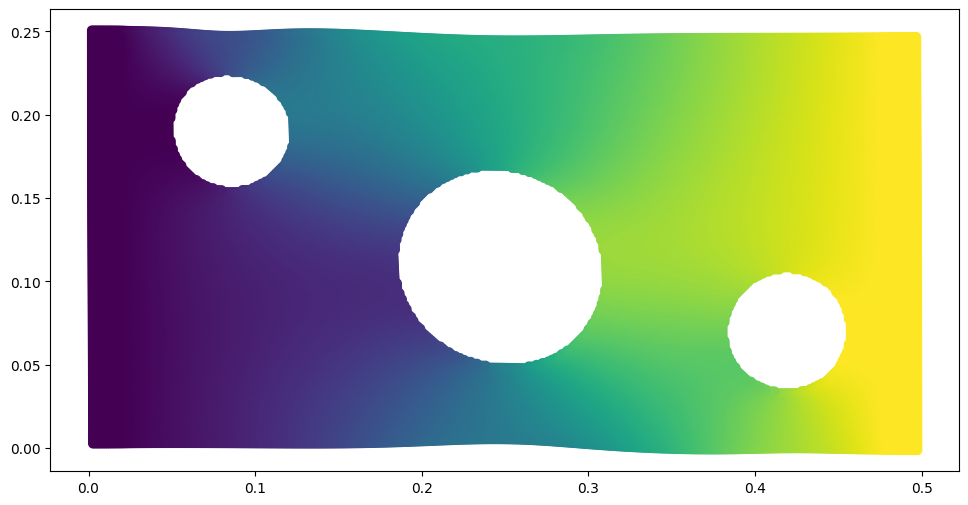

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    model.particles.x[:, 0] + (model.particles.u[:, 1] * dsf),
    model.particles.x[:, 1] + (model.particles.u[:, 1] * dsf),
    c=model.particles.u[:, 0],
)
ax.set_aspect("equal")

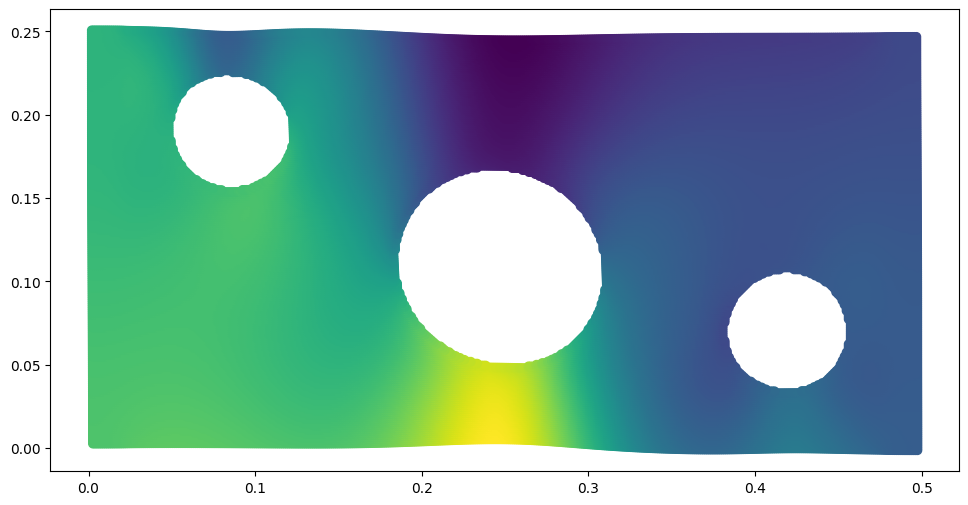

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    model.particles.x[:, 0] + (model.particles.u[:, 1] * dsf),
    model.particles.x[:, 1] + (model.particles.u[:, 1] * dsf),
    c=model.particles.u[:, 1],
)
ax.set_aspect("equal")